Using device: cuda
GPU: Tesla T4
🚀 Starting HAM10000 Dataset Loading on Kaggle
📂 Setting up Kaggle dataset paths...
Found dataset at: /kaggle/input/skin-cancer-mnist-ham10000
Using metadata file: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
Loaded metadata with 10015 rows
🔍 Searching for image files...
Found 10015 image files
✅ Final dataset size: 10015 samples

📊 Class Distribution:
----------------------------------------
nv    :  6705 (66.95 %)
mel   :  1113 (11.11 %)
bkl   :  1099 (10.97 %)
bcc   :   514 ( 5.13 %)
akiec :   327 ( 3.27 %)
vasc  :   142 ( 1.42 %)
df    :   115 ( 1.15 %)

🎯 Creating train-validation split...

⚖️  Class Weights (for loss balancing):
nv    : 0.0460
mel   : 0.2775
bkl   : 0.2810
bcc   : 0.6010
akiec : 0.9428
vasc  : 2.1667
df    : 2.6849

📈 Dataset Statistics:
  Training samples: 8,012
  Validation samples: 2,003
  Total samples: 10,015


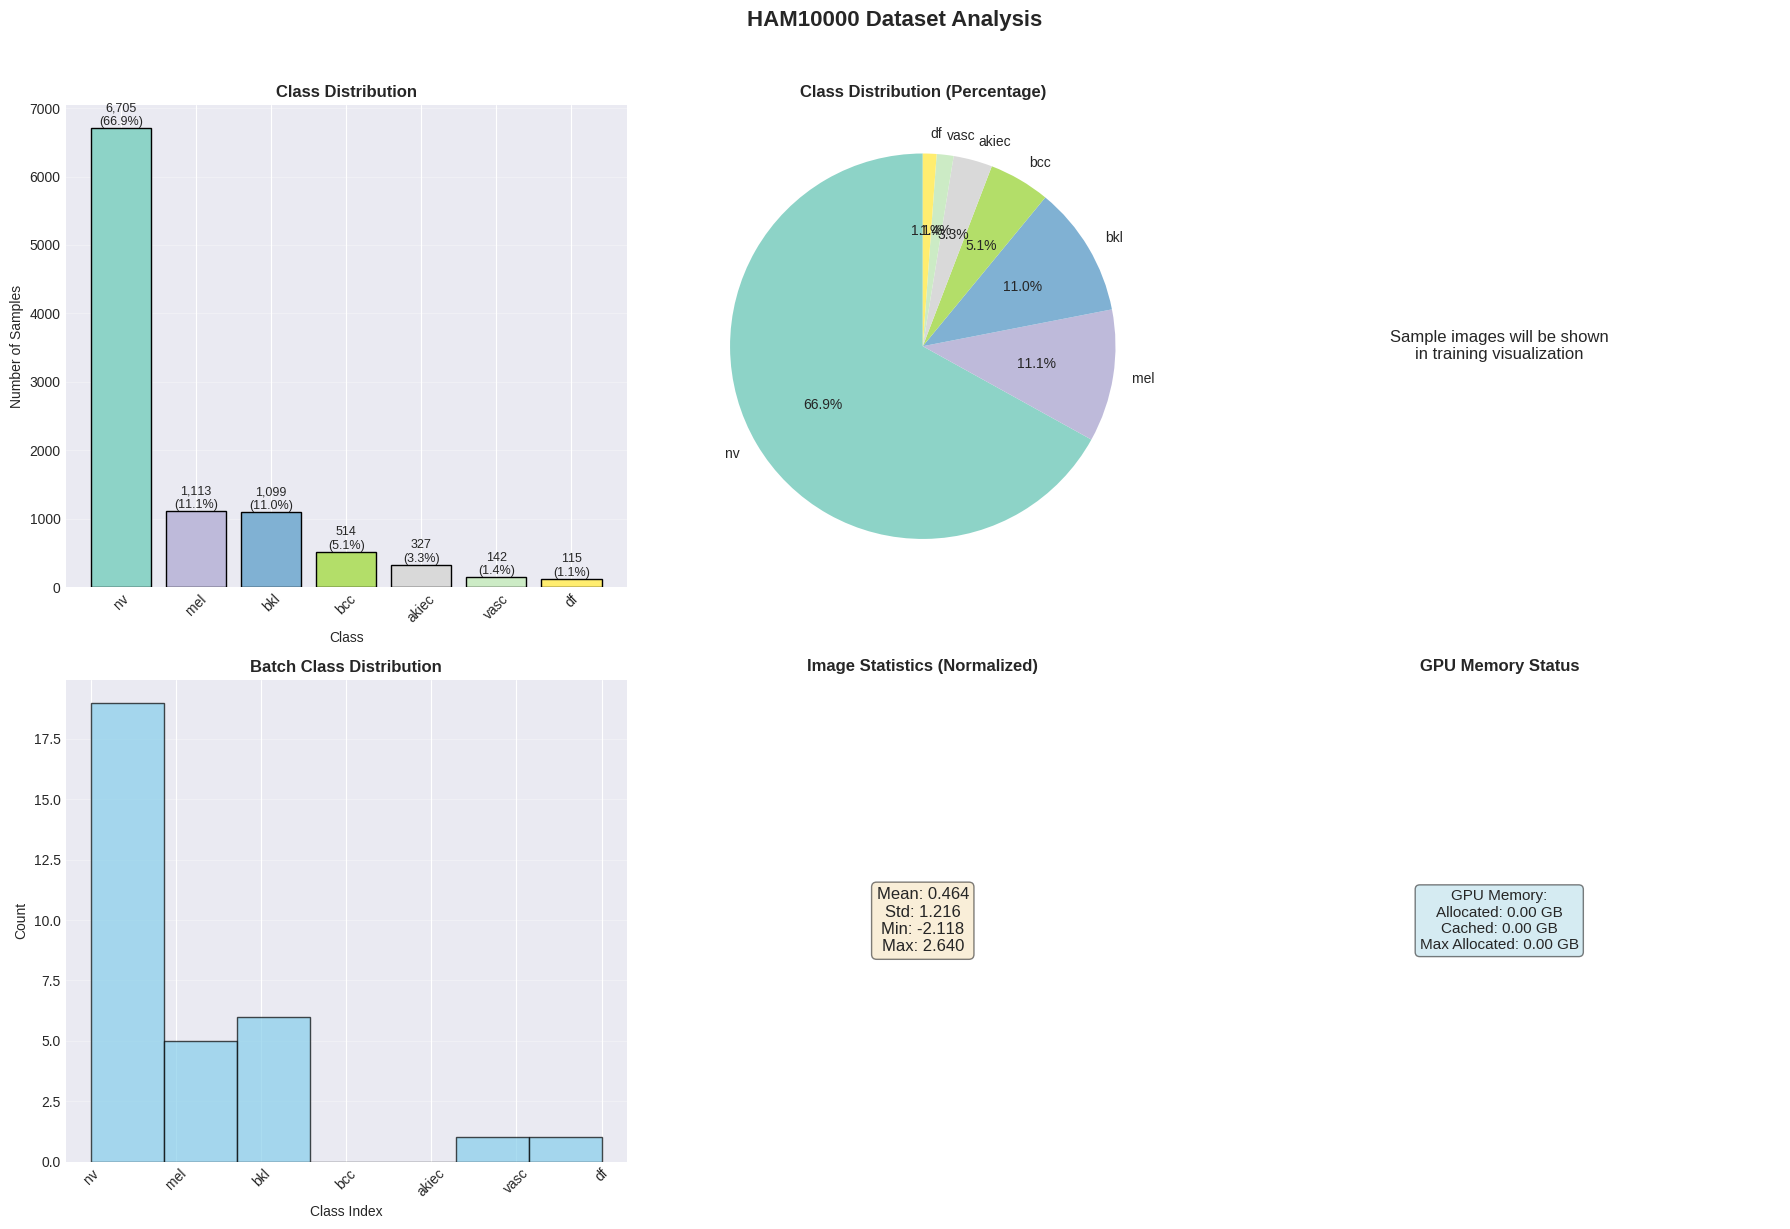


✅ Data loading complete!


In [1]:
# =========== CELL 1: SETUP & IMPORTS ===========
"""
Class-Aware Transfer Learning (CATL) for HAM10000 - Kaggle Version
Part 1: Setup, Imports, and Data Loading for Kaggle
"""

import os
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# HAM10000 class mapping
CLASS_NAMES = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

# Data transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# =========== CELL 2: DATASET CLASS & DATA LOADING ===========
class HAM10000Dataset(Dataset):
    """HAM10000 Dataset with efficient loading"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.cache = {}  # Simple cache for loaded images
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
        else:
            img_path = self.image_paths[idx]
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                # Create a blank image if file is corrupted
                image = Image.new('RGB', (224, 224), color='black')
            
            label = self.labels[idx]
            self.cache[idx] = (image, label)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def load_kaggle_dataset():
    """
    Load HAM10000 dataset from Kaggle directory structure
    """
    print("📂 Setting up Kaggle dataset paths...")
    
    # Kaggle dataset paths
    kaggle_base = '/kaggle/input/skin-cancer-mnist-ham10000'
    
    # Check different possible folder structures in Kaggle
    possible_paths = [
        '/kaggle/input/skin-cancer-mnist-ham10000',
        '/kaggle/input/ham10000',
        '/kaggle/input/skin-cancer',
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            kaggle_base = path
            print(f"Found dataset at: {path}")
            break
    
    # Look for metadata file
    metadata_files = []
    for root, dirs, files in os.walk(kaggle_base):
        for file in files:
            if 'metadata' in file.lower() and file.endswith('.csv'):
                metadata_files.append(os.path.join(root, file))
    
    if not metadata_files:
        # Try to find HAM10000_metadata.csv specifically
        metadata_path = os.path.join(kaggle_base, 'HAM10000_metadata.csv')
        if os.path.exists(metadata_path):
            metadata_files = [metadata_path]
    
    if not metadata_files:
        raise FileNotFoundError("Could not find metadata CSV file")
    
    metadata_path = metadata_files[0]
    print(f"Using metadata file: {metadata_path}")
    
    # Load metadata
    df = pd.read_csv(metadata_path)
    print(f"Loaded metadata with {len(df)} rows")
    
    # Find image files - search recursively
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = {}
    
    print("🔍 Searching for image files...")
    for root, dirs, files in os.walk(kaggle_base):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                file_path = os.path.join(root, file)
                # Extract image_id from filename (remove extension)
                image_id = os.path.splitext(file)[0]
                image_files[image_id] = file_path
    
    print(f"Found {len(image_files)} image files")
    
    # Map image_ids from metadata to their actual paths
    df['image_path'] = df['image_id'].map(image_files)
    
    # Drop rows for which no image file was found
    initial_len = len(df)
    df = df.dropna(subset=['image_path']).reset_index(drop=True)
    if len(df) < initial_len:
        print(f"⚠️  Dropped {initial_len - len(df)} rows due to missing image files")
    
    if len(df) == 0:
        raise ValueError("❌ No images found after filtering missing paths")
    
    # Map labels to indices
    df['label_idx'] = df['dx'].map(CLASS_TO_IDX)
    
    # Handle any NaN labels
    df = df.dropna(subset=['label_idx']).reset_index(drop=True)
    
    print(f"✅ Final dataset size: {len(df)} samples")
    
    # Calculate class distribution
    class_counts = df['dx'].value_counts().to_dict()
    total_samples = len(df)
    
    print("\n📊 Class Distribution:")
    print("-" * 40)
    for cls in CLASS_NAMES:
        count = class_counts.get(cls, 0)
        pct = 100 * count / total_samples
        print(f"{cls:6s}: {count:5d} ({pct:5.2f} %)")
    
    # Stratified train-validation split
    print("\n🎯 Creating train-validation split...")
    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df['label_idx'], random_state=42
    )
    
    # Calculate class weights for loss function
    train_counts = train_df['label_idx'].value_counts().sort_index().values
    class_weights = torch.FloatTensor(total_samples / (len(CLASS_NAMES) * train_counts))
    class_weights = class_weights / class_weights.sum() * len(CLASS_NAMES)
    
    print("\n⚖️  Class Weights (for loss balancing):")
    for idx, weight in enumerate(class_weights):
        print(f"{CLASS_NAMES[idx]:6s}: {weight:.4f}")
    
    # Create datasets
    train_dataset = HAM10000Dataset(
        train_df['image_path'].values,
        train_df['label_idx'].values,
        transform=train_transforms
    )
    
    val_dataset = HAM10000Dataset(
        val_df['image_path'].values,
        val_df['label_idx'].values,
        transform=val_transforms
    )
    
    # Create dataloaders with Kaggle-optimized settings
    num_workers = 2 if torch.cuda.is_available() else 0
    pin_memory = torch.cuda.is_available()
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True if num_workers > 0 else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True if num_workers > 0 else False
    )
    
    print(f"\n📈 Dataset Statistics:")
    print(f"  Training samples: {len(train_dataset):,}")
    print(f"  Validation samples: {len(val_dataset):,}")
    print(f"  Total samples: {len(train_dataset) + len(val_dataset):,}")
    
    return train_loader, val_loader, class_weights, class_counts, df

# =========== CELL 3: VISUALIZE DATA DISTRIBUTION ===========
def visualize_data_distribution(class_counts, train_loader, val_loader):
    """Create comprehensive data visualization"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('HAM10000 Dataset Analysis', fontsize=16, fontweight='bold', y=1.02)
    
    # 1. Class distribution bar plot
    counts = [class_counts.get(cls, 0) for cls in CLASS_NAMES]
    colors = plt.cm.Set3(np.linspace(0, 1, len(CLASS_NAMES)))
    
    bars = axes[0, 0].bar(CLASS_NAMES, counts, color=colors, edgecolor='black')
    axes[0, 0].set_title('Class Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Number of Samples')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    total = sum(counts)
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        percentage = 100 * count / total
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, height,
                       f'{count:,}\n({percentage:.1f}%)',
                       ha='center', va='bottom', fontsize=9)
    
    # 2. Pie chart of class distribution
    axes[0, 1].pie(counts, labels=CLASS_NAMES, autopct='%1.1f%%',
                   colors=colors, startangle=90)
    axes[0, 1].set_title('Class Distribution (Percentage)', fontweight='bold')
    
    # 3. Sample images from each class
    axes[0, 2].axis('off')
    axes[0, 2].text(0.5, 0.5, 'Sample images will be shown\nin training visualization',
                   ha='center', va='center', fontsize=12, transform=axes[0, 2].transAxes)
    
    # 4. Batch statistics
    train_batch = next(iter(train_loader))
    images, labels = train_batch
    axes[1, 0].hist(labels.numpy(), bins=len(CLASS_NAMES), 
                   color='skyblue', edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Batch Class Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Class Index')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_xticks(range(len(CLASS_NAMES)))
    axes[1, 0].set_xticklabels([IDX_TO_CLASS[i] for i in range(len(CLASS_NAMES))], rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 5. Image statistics
    image_stats = {
        'Mean': images.mean().item(),
        'Std': images.std().item(),
        'Min': images.min().item(),
        'Max': images.max().item()
    }
    
    stats_text = '\n'.join([f'{k}: {v:.3f}' for k, v in image_stats.items()])
    axes[1, 1].text(0.5, 0.5, stats_text, ha='center', va='center',
                   fontsize=12, transform=axes[1, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 1].set_title('Image Statistics (Normalized)', fontweight='bold')
    axes[1, 1].axis('off')
    
    # 6. Memory usage
    axes[1, 2].axis('off')
    if torch.cuda.is_available():
        memory_info = f"GPU Memory:\n"
        memory_info += f"Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB\n"
        memory_info += f"Cached: {torch.cuda.memory_reserved()/1e9:.2f} GB\n"
        memory_info += f"Max Allocated: {torch.cuda.max_memory_allocated()/1e9:.2f} GB"
        axes[1, 2].text(0.5, 0.5, memory_info, ha='center', va='center',
                       fontsize=11, transform=axes[1, 2].transAxes,
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        axes[1, 2].set_title('GPU Memory Status', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/data_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# =========== CELL 4: LOAD DATA ===========
print("🚀 Starting HAM10000 Dataset Loading on Kaggle")
print("="*60)

# Load the dataset
train_loader, val_loader, class_weights, class_counts, full_df = load_kaggle_dataset()

# Visualize data distribution
data_fig = visualize_data_distribution(class_counts, train_loader, val_loader)

print("\n✅ Data loading complete!")
print("="*60)

In [2]:
# =========== CELL 5: MODEL ARCHITECTURE ===========
"""
CATL Model Architecture for Kaggle
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np

class ClassSpecificHead(nn.Module):
    """Individual classifier head for each class"""
    
    def __init__(self, in_features, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),  # Using GELU instead of ReLU for better performance
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.head(x)

class CATLModel(nn.Module):
    """
    Class-Aware Transfer Learning Model for Kaggle
    Shared backbone + class-specific heads architecture
    """
    
    def __init__(self, num_classes=7, backbone='efficientnet', hidden_dim=256, dropout=0.3):
        super().__init__()
        self.num_classes = num_classes
        
        # Initialize backbone
        if backbone == 'efficientnet':
            # EfficientNet with weights
            self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
            self.backbone_name = 'efficientnet_b0'
        elif backbone == 'resnet50':
            # ResNet50 with weights
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone_name = 'resnet50'
        elif backbone == 'densenet121':
            # DenseNet121 with weights
            self.backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone_name = 'densenet121'
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        self.in_features = in_features
        
        # Create class-specific heads
        self.heads = nn.ModuleList([
            ClassSpecificHead(in_features, hidden_dim, dropout)
            for _ in range(num_classes)
        ])
        
        # Freeze backbone initially
        self.freeze_backbone()
        
        # Store unfrozen blocks info
        self.unfrozen_blocks = 0
        
        # Adaptive pooling
        if backbone in ['resnet50']:
            self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        print(f"✅ Model initialized with {backbone} backbone")
    
    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.unfrozen_blocks = 0
    
    def unfreeze_backbone_blocks(self, num_blocks):
        """
        Unfreeze last N blocks of backbone
        """
        if num_blocks == self.unfrozen_blocks:
            return
        
        # Refreeze everything first
        self.freeze_backbone()
        
        if self.backbone_name == 'efficientnet_b0':
            # EfficientNet B0: 9 blocks in features
            blocks = list(self.backbone.features.children())
            total_blocks = len(blocks)
            unfreeze_from = max(0, total_blocks - num_blocks)
            
            for i, block in enumerate(blocks):
                if i >= unfreeze_from:
                    for param in block.parameters():
                        param.requires_grad = True
        
        elif self.backbone_name == 'resnet50':
            # ResNet50: unfreeze layer4, layer3, etc.
            layers = [self.backbone.layer4, self.backbone.layer3, 
                     self.backbone.layer2, self.backbone.layer1]
            
            # Only unfreeze the specified number of layers
            for i in range(min(num_blocks, len(layers))):
                for param in layers[i].parameters():
                    param.requires_grad = True
        
        elif self.backbone_name == 'densenet121':
            # DenseNet121: unfreeze last dense blocks
            features = list(self.backbone.features.children())
            # DenseNet has 4 dense blocks + transition layers
            # We'll unfreeze from the end
            total_blocks = len(features)
            unfreeze_from = max(0, total_blocks - num_blocks * 2)  # Approximate
        
        self.unfrozen_blocks = num_blocks
    
    def forward(self, x):
        """
        Forward pass
        """
        # Extract features from backbone
        features = self.backbone(x)
        
        # For models that output spatial features
        if features.dim() == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)
        
        # Ensure features are 2D [B, in_features]
        if features.dim() > 2:
            features = features.view(features.size(0), -1)
        
        # Pass through each class-specific head
        logits = []
        for head in self.heads:
            logits.append(head(features))
        
        # Concatenate all class logits
        logits = torch.cat(logits, dim=1)  # [B, num_classes]
        
        return logits
    
    def get_feature_importance(self, class_idx):
        """
        Get feature importance for a specific class
        Returns the weights of the first layer in the head
        """
        if 0 <= class_idx < len(self.heads):
            first_layer = self.heads[class_idx].head[0]
            if isinstance(first_layer, nn.Linear):
                weights = first_layer.weight.data.abs().mean(dim=0)
                return weights.cpu().numpy()
        return None
    
    def get_trainable_parameters_count(self):
        """Get count of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

def count_parameters(model):
    """Count trainable and total parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

def model_summary(model):
    """Print model architecture summary"""
    print("\n" + "="*60)
    print(f"CATL Model Summary ({model.backbone_name})")
    print("="*60)
    
    print(f"\nBackbone: {model.backbone_name}")
    print(f"Feature dimension: {model.in_features}")
    print(f"Number of classes: {model.num_classes}")
    print(f"Number of heads: {len(model.heads)}")
    print(f"Unfrozen blocks: {model.unfrozen_blocks}")
    
    trainable, total = count_parameters(model)
    print(f"\nTotal parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    print(f"Frozen parameters: {total - trainable:,}")
    print(f"Trainable ratio: {100*trainable/total:.2f}%")
    
    # Backbone vs heads breakdown
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    heads_params = sum(p.numel() for p in model.heads.parameters())
    
    print(f"\nBackbone parameters: {backbone_params:,}")
    print(f"Heads parameters: {heads_params:,}")
    
    # Memory estimate
    if torch.cuda.is_available():
        memory_bytes = total * 4  # Assuming float32
        print(f"\nEstimated GPU memory: {memory_bytes/1e9:.2f} GB")
    
    print("="*60 + "\n")

# =========== CELL 6: CREATE AND TEST MODEL ===========
print("🏗️  Creating CATL Model for Kaggle")
print("="*60)

# Create model (choose backbone: efficientnet, resnet50, or densenet121)
model = CATLModel(
    num_classes=7,
    backbone='efficientnet',  # Change to 'resnet50' or 'densenet121' if desired
    hidden_dim=256,
    dropout=0.3
)

model = model.to(device)
model_summary(model)

# Test forward pass
print("🧪 Testing forward pass...")
dummy_input = torch.randn(4, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min().item():.3f}, {output.max().item():.3f}]")

# Test feature importance extraction
print("\n🔍 Testing feature importance extraction...")
for i in range(min(3, len(CLASS_NAMES))):  # Test first 3 classes
    importance = model.get_feature_importance(i)
    if importance is not None:
        print(f"  {CLASS_NAMES[i]}: Feature importance shape: {importance.shape}")
        print(f"    Mean importance: {importance.mean():.4f}, Max: {importance.max():.4f}")

print("\n✅ Model creation complete!")

🏗️  Creating CATL Model for Kaggle
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]


✅ Model initialized with efficientnet backbone

CATL Model Summary (efficientnet_b0)

Backbone: efficientnet_b0
Feature dimension: 1280
Number of classes: 7
Number of heads: 7
Unfrozen blocks: 0

Total parameters: 6,539,651
Trainable parameters: 2,532,103
Frozen parameters: 4,007,548
Trainable ratio: 38.72%

Backbone parameters: 4,007,548
Heads parameters: 2,532,103

Estimated GPU memory: 0.03 GB

🧪 Testing forward pass...
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 7])
Output range: [-34.696, 28.785]

🔍 Testing feature importance extraction...
  nv: Feature importance shape: (1280,)
    Mean importance: 0.0705, Max: 0.0815
  mel: Feature importance shape: (1280,)
    Mean importance: 0.0707, Max: 0.0814
  bkl: Feature importance shape: (1280,)
    Mean importance: 0.0706, Max: 0.0811

✅ Model creation complete!


In [3]:
# =========== CELL 7: TRAINING COMPONENTS ===========
"""
Training Components for Kaggle
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support
from tqdm import tqdm
import time
from collections import defaultdict
import json

class AdaptiveFocalLoss(nn.Module):
    """
    Adaptive Focal Loss with class balancing and adaptive gamma
    Paper: https://arxiv.org/abs/1708.02002
    """
    
    def __init__(self, alpha=None, gamma=2.0, adaptive_gamma=True, label_smoothing=0.1, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Class weights [C]
        self.base_gamma = gamma
        self.adaptive_gamma = adaptive_gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction
        self.eps = 1e-7
        
    def forward(self, logits, targets):
        """
        Args:
            logits: [B, C] raw logits
            targets: [B] class indices
        """
        # Apply label smoothing
        if self.label_smoothing > 0:
            num_classes = logits.size(-1)
            smooth_targets = F.one_hot(targets, num_classes).float()
            smooth_targets = smooth_targets * (1 - self.label_smoothing) + self.label_smoothing / num_classes
            ce_loss = -torch.sum(smooth_targets * F.log_softmax(logits, dim=-1), dim=-1)
        else:
            ce_loss = F.cross_entropy(logits, targets, reduction='none')
        
        # Get probabilities
        pt = torch.exp(-ce_loss)  # p_t = p if y=1 else 1-p
        pt = torch.clamp(pt, self.eps, 1 - self.eps)  # Avoid numerical issues
        
        # Adaptive gamma
        if self.adaptive_gamma:
            with torch.no_grad():
                probs = F.softmax(logits, dim=1)
                target_probs = probs[torch.arange(len(targets)), targets]
                # Higher gamma for harder samples (lower confidence)
                gamma = self.base_gamma * (1.5 - target_probs.mean().item())
                gamma = max(0.5, min(3.0, gamma))  # Clip gamma
        else:
            gamma = self.base_gamma
        
        # Focal loss component
        focal_term = (1 - pt) ** gamma
        
        # Class balancing
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * focal_term * ce_loss
        else:
            loss = focal_term * ce_loss
        
        # Reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class KaggleMetricsTracker:
    """Advanced metrics tracker optimized for Kaggle"""
    
    def __init__(self, num_classes, class_names):
        self.num_classes = num_classes
        self.class_names = class_names
        self.reset()
    
    def reset(self):
        self.all_preds = []
        self.all_targets = []
        self.all_probs = []
        self.all_logits = []
        self.running_loss = 0.0
        self.n_samples = 0
        
        # Per-class tracking
        self.class_correct = np.zeros(self.num_classes)
        self.class_total = np.zeros(self.num_classes)
        self.class_loss = np.zeros(self.num_classes)
    
    def update(self, logits, targets, loss, batch_size):
        # Get predictions
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        # Convert to numpy
        preds_np = preds.detach().cpu().numpy()
        targets_np = targets.detach().cpu().numpy()
        probs_np = probs.detach().cpu().numpy()
        logits_np = logits.detach().cpu().numpy()
        
        # Store
        self.all_preds.extend(preds_np)
        self.all_targets.extend(targets_np)
        self.all_probs.extend(probs_np)
        self.all_logits.extend(logits_np)
        
        # Update running statistics
        self.running_loss += loss.item() * batch_size
        self.n_samples += batch_size
        
        # Update per-class statistics
        for cls in range(self.num_classes):
            mask = (targets_np == cls)
            if mask.any():
                self.class_correct[cls] += (preds_np[mask] == targets_np[mask]).sum()
                self.class_total[cls] += mask.sum()
                # Average loss for this class in this batch
                if loss.dim() > 0:  # If loss is per-sample
                    self.class_loss[cls] += loss[mask].sum().item()
                else:
                    # Distribute total loss equally (approximation)
                    self.class_loss[cls] += loss.item() * mask.sum() / batch_size
    
    def compute(self):
        if self.n_samples == 0:
            return {}
        
        # Convert to numpy arrays
        preds = np.array(self.all_preds)
        targets = np.array(self.all_targets)
        probs = np.array(self.all_probs)
        
        # Basic metrics
        avg_loss = self.running_loss / self.n_samples
        accuracy = (preds == targets).mean()
        
        # F1 scores
        macro_f1 = f1_score(targets, preds, average='macro', zero_division=0)
        micro_f1 = f1_score(targets, preds, average='micro', zero_division=0)
        
        # Per-class metrics
        per_class_f1 = f1_score(targets, preds, average=None, zero_division=0)
        precision, recall, _, _ = precision_recall_fscore_support(
            targets, preds, average=None, zero_division=0
        )
        
        # Per-class accuracy
        per_class_accuracy = np.zeros(self.num_classes)
        for cls in range(self.num_classes):
            if self.class_total[cls] > 0:
                per_class_accuracy[cls] = self.class_correct[cls] / self.class_total[cls]
        
        # AUC scores (one-vs-rest)
        per_class_auc = np.zeros(self.num_classes)
        for cls in range(self.num_classes):
            try:
                binary_targets = (targets == cls).astype(int)
                class_probs = probs[:, cls]
                if len(np.unique(binary_targets)) > 1:
                    auc = roc_auc_score(binary_targets, class_probs)
                    per_class_auc[cls] = auc
                else:
                    per_class_auc[cls] = 0.5
            except:
                per_class_auc[cls] = 0.5
        
        # Per-class average loss
        per_class_loss = np.zeros(self.num_classes)
        for cls in range(self.num_classes):
            if self.class_total[cls] > 0:
                per_class_loss[cls] = self.class_loss[cls] / self.class_total[cls]
        
        # Confusion matrix
        cm = confusion_matrix(targets, preds)
        
        # Additional metrics
        balanced_accuracy = per_class_accuracy.mean()
        
        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'macro_f1': macro_f1,
            'micro_f1': micro_f1,
            'per_class_f1': per_class_f1,
            'per_class_precision': precision,
            'per_class_recall': recall,
            'per_class_auc': per_class_auc,
            'per_class_accuracy': per_class_accuracy,
            'per_class_loss': per_class_loss,
            'confusion_matrix': cm,
            'predictions': preds,
            'targets': targets,
            'probabilities': probs,
            'n_samples': self.n_samples
        }
    
    def get_classification_report(self):
        """Generate detailed classification report"""
        if len(self.all_targets) == 0:
            return ""
        
        from sklearn.metrics import classification_report
        return classification_report(
            self.all_targets, self.all_preds,
            target_names=self.class_names,
            digits=4
        )

class KaggleCATLTrainer:
    """Kaggle-optimized CATL Trainer with advanced features"""
    
    def __init__(self, model, train_loader, val_loader, class_weights,
                 lr=1e-3, backbone_lr_ratio=0.1, gamma=2.0, num_epochs=20, 
                 device='cuda', save_dir='/kaggle/working'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        
        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
        
        # Loss function
        alpha = class_weights.to(device)
        self.criterion = AdaptiveFocalLoss(
            alpha=alpha, 
            gamma=gamma, 
            adaptive_gamma=True,
            label_smoothing=0.1
        )
        
        # Separate optimizers for heads and backbone
        head_params = list(model.heads.parameters())
        backbone_params = [p for p in model.backbone.parameters() if p.requires_grad]
        
        self.optimizer = AdamW([
            {'params': head_params, 'lr': lr, 'weight_decay': 1e-4},
            {'params': backbone_params, 'lr': lr * backbone_lr_ratio, 'weight_decay': 1e-4}
        ])
        
        # OneCycleLR scheduler for fast convergence
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=[lr, lr * backbone_lr_ratio],
            epochs=num_epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3,
            anneal_strategy='cos'
        )
        
        # Metrics trackers
        self.train_metrics = KaggleMetricsTracker(model.num_classes, CLASS_NAMES)
        self.val_metrics = KaggleMetricsTracker(model.num_classes, CLASS_NAMES)
        
        # Training history
        self.history = {
            'epoch': [],
            'train_loss': [], 'val_loss': [],
            'train_f1': [], 'val_f1': [],
            'train_acc': [], 'val_acc': [],
            'train_balanced_acc': [], 'val_balanced_acc': [],
            'per_class_f1': [], 'per_class_auc': [],
            'per_class_acc': [], 'learning_rates': [],
            'unfrozen_blocks': [], 'batch_times': []
        }
        
        # Best model tracking
        self.best_val_f1 = 0.0
        self.best_val_balanced_acc = 0.0
        self.best_model_state = None
        self.best_epoch = 0
        
        # Early stopping
        self.patience = 7
        self.counter = 0
        
        # Gradient accumulation for larger effective batch size
        self.gradient_accumulation_steps = 1
        
        # Mixed precision training
        self.scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        
        print(f"✅ Trainer initialized for {num_epochs} epochs")
        print(f"   Learning rates: Heads={lr:.1e}, Backbone={lr*backbone_lr_ratio:.1e}")
        print(f"   Save directory: {save_dir}")
    
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        self.train_metrics.reset()
        
        epoch_loss = 0.0
        batch_times = []
        
        # Create progress bar
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1:02d}/{self.num_epochs} [Train]')
        
        for batch_idx, (images, labels) in enumerate(pbar):
            batch_start = time.time()
            
            images, labels = images.to(self.device), labels.to(self.device)
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast(enabled=self.scaler is not None):
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                
                # Gradient accumulation
                loss = loss / self.gradient_accumulation_steps
            
            # Backward pass
            if self.scaler is not None:
                self.scaler.scale(loss).backward()
            else:
                loss.backward()
            
            # Gradient accumulation step
            if (batch_idx + 1) % self.gradient_accumulation_steps == 0:
                # Gradient clipping
                if self.scaler is not None:
                    self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                # Optimizer step
                if self.scaler is not None:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
                
                self.optimizer.zero_grad()
                
                # Update scheduler
                self.scheduler.step()
            
            # Update metrics
            self.train_metrics.update(logits, labels, loss * self.gradient_accumulation_steps, len(images))
            epoch_loss += loss.item() * len(images) * self.gradient_accumulation_steps
            
            # Timing
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)
            
            # Update progress bar
            if batch_idx % 10 == 0:
                current_loss = self.train_metrics.running_loss / self.train_metrics.n_samples
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'lr': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
                })
        
        # Compute metrics
        train_results = self.train_metrics.compute()
        
        # Store batch times
        avg_batch_time = np.mean(batch_times) if batch_times else 0
        self.history['batch_times'].append(avg_batch_time)
        
        return train_results
    
    def validate_epoch(self, epoch):
        """Validate for one epoch"""
        self.model.eval()
        self.val_metrics.reset()
        
        pbar = tqdm(self.val_loader, desc=f'Epoch {epoch+1:02d}/{self.num_epochs} [Val]')
        
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Forward pass
                with torch.cuda.amp.autocast(enabled=self.scaler is not None):
                    logits = self.model(images)
                    loss = self.criterion(logits, labels)
                
                # Update metrics
                self.val_metrics.update(logits, labels, loss, len(images))
                
                # Update progress bar
                current_loss = self.val_metrics.running_loss / self.val_metrics.n_samples
                pbar.set_postfix({'loss': f'{current_loss:.4f}'})
        
        return self.val_metrics.compute()
    
    def progressive_unfreeze(self, epoch, val_f1):
        """Enhanced progressive unfreezing for Kaggle"""
        
        # More conservative unfreezing schedule for Kaggle
        unfreeze_schedule = [
            {'epoch': 3, 'blocks': 1, 'min_f1': 0.3},
            {'epoch': 6, 'blocks': 2, 'min_f1': 0.4},
            {'epoch': 10, 'blocks': 3, 'min_f1': 0.5},
            {'epoch': 14, 'blocks': 4, 'min_f1': 0.55},
        ]
        
        for schedule in unfreeze_schedule:
            if epoch == schedule['epoch'] and val_f1 >= schedule['min_f1']:
                if self.model.unfrozen_blocks < schedule['blocks']:
                    print(f"\n  🔓 [Unfreezing] Unfreezing {schedule['blocks']} blocks (F1: {val_f1:.3f})")
                    self.model.unfreeze_backbone_blocks(schedule['blocks'])
                    
                    # Adjust learning rates after unfreezing
                    self._adjust_learning_rates_after_unfreeze()
                    
                    # Reset scheduler for new parameters
                    self._reset_scheduler()
                    
                    return True
        
        return False
    
    def _adjust_learning_rates_after_unfreeze(self):
        """Adjust learning rates after unfreezing"""
        # Gradually increase backbone LR as we unfreeze more
        current_blocks = self.model.unfrozen_blocks
        backbone_lr_multiplier = min(2 ** (current_blocks - 1), 4)
        
        # Update backbone learning rate
        for param_group in self.optimizer.param_groups:
            if len(param_group['params']) > 0 and 'backbone' in str(param_group['params'][0].device):
                base_lr = param_group['initial_lr'] if hasattr(param_group, 'initial_lr') else param_group['lr']
                param_group['lr'] = base_lr * backbone_lr_multiplier
        
        print(f"    Adjusted backbone LR multiplier: {backbone_lr_multiplier}x")
    
    def _reset_scheduler(self):
        """Reset scheduler after unfreezing"""
        # Reinitialize scheduler with current optimizer
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=[self.optimizer.param_groups[0]['lr'], 
                   self.optimizer.param_groups[1]['lr']],
            epochs=self.num_epochs,
            steps_per_epoch=len(self.train_loader),
            pct_start=0.1,  # Shorter warmup after unfreezing
            anneal_strategy='cos'
        )
    
    def save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'history': self.history,
            'best_val_f1': self.best_val_f1,
            'best_epoch': self.best_epoch,
            'unfrozen_blocks': self.model.unfrozen_blocks
        }
        
        if self.scaler is not None:
            checkpoint['scaler_state_dict'] = self.scaler.state_dict()
        
        # Save regular checkpoint
        checkpoint_path = os.path.join(self.save_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Save best model separately
        if is_best:
            best_path = os.path.join(self.save_dir, 'best_model.pth')
            torch.save(checkpoint, best_path)
            print(f"    💾 Best model saved to: {best_path}")
        
        # Also save as .pkl for compatibility
        import pickle
        with open(os.path.join(self.save_dir, f'history_epoch_{epoch+1}.pkl'), 'wb') as f:
            pickle.dump(self.history, f)
    
    def train(self):
        """Main training loop optimized for Kaggle"""
        print("\n" + "="*70)
        print("🚀 Starting Kaggle-Optimized CATL Training")
        print(f"📊 Epochs: {self.num_epochs}, Device: {self.device}")
        print("="*70)
        
        start_time = time.time()
        
        for epoch in range(self.num_epochs):
            epoch_start = time.time()
            
            print(f"\n{'='*60}")
            print(f"📈 Epoch {epoch+1}/{self.num_epochs}")
            print(f"{'='*60}")
            
            # Train
            train_results = self.train_epoch(epoch)
            
            # Validate
            val_results = self.validate_epoch(epoch)
            
            # Progressive unfreezing
            unfroze = self.progressive_unfreeze(epoch, val_results['macro_f1'])
            
            # Update history
            self._update_history(epoch, train_results, val_results)
            
            # Check for best model
            is_best = False
            if val_results['macro_f1'] > self.best_val_f1:
                self.best_val_f1 = val_results['macro_f1']
                self.best_val_balanced_acc = val_results['balanced_accuracy']
                self.best_epoch = epoch
                self.best_model_state = self.model.state_dict().copy()
                self.counter = 0
                is_best = True
                print(f"    🏆 New best model! F1: {self.best_val_f1:.4f}, Balanced Acc: {self.best_val_balanced_acc:.4f}")
            else:
                self.counter += 1
                if self.counter >= 3:
                    print(f"    ⚠️  No improvement for {self.counter} epochs")
            
            # Save checkpoint (save more frequently in Kaggle)
            if (epoch + 1) % 5 == 0 or is_best or epoch == self.num_epochs - 1:
                self.save_checkpoint(epoch, is_best)
            
            # Print epoch summary
            epoch_time = time.time() - epoch_start
            self._print_epoch_summary(epoch, train_results, val_results, epoch_time, unfroze)
            
            # Early stopping
            if self.counter >= self.patience:
                print(f"\n    ⏹️  [Early Stopping] No improvement for {self.patience} epochs")
                break
        
        # Training complete
        total_time = time.time() - start_time
        
        print(f"\n{'='*70}")
        print("✅ Training Complete!")
        print(f"   Total time: {total_time/60:.1f} minutes")
        print(f"   Best epoch: {self.best_epoch + 1}")
        print(f"   Best Validation F1: {self.best_val_f1:.4f}")
        print(f"   Best Balanced Accuracy: {self.best_val_balanced_acc:.4f}")
        print(f"{'='*70}\n")
        
        # Load best model for evaluation
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
        
        # Save final model and history
        self.save_final_results()
        
        return self.history
    
    def _update_history(self, epoch, train_results, val_results):
        """Update training history"""
        self.history['epoch'].append(epoch + 1)
        self.history['train_loss'].append(train_results['loss'])
        self.history['val_loss'].append(val_results['loss'])
        self.history['train_f1'].append(train_results['macro_f1'])
        self.history['val_f1'].append(val_results['macro_f1'])
        self.history['train_acc'].append(train_results['accuracy'])
        self.history['val_acc'].append(val_results['accuracy'])
        self.history['train_balanced_acc'].append(train_results['balanced_accuracy'])
        self.history['val_balanced_acc'].append(val_results['balanced_accuracy'])
        self.history['per_class_f1'].append(val_results['per_class_f1'])
        self.history['per_class_auc'].append(val_results['per_class_auc'])
        self.history['per_class_acc'].append(val_results['per_class_accuracy'])
        self.history['unfrozen_blocks'].append(self.model.unfrozen_blocks)
        
        # Current learning rates
        current_lrs = [param_group['lr'] for param_group in self.optimizer.param_groups]
        self.history['learning_rates'].append(current_lrs)
    
    def _print_epoch_summary(self, epoch, train_results, val_results, epoch_time, unfroze):
        """Print detailed epoch summary"""
        print(f"\n  📊 Epoch {epoch+1} Summary ({epoch_time:.1f}s):")
        print(f"    Train - Loss: {train_results['loss']:.4f}, "
              f"F1: {train_results['macro_f1']:.4f}, "
              f"Acc: {train_results['accuracy']:.4f}")
        print(f"    Val   - Loss: {val_results['loss']:.4f}, "
              f"F1: {val_results['macro_f1']:.4f}, "
              f"Acc: {val_results['accuracy']:.4f}")
        
        if unfroze:
            print(f"    🔓 [Unfreezing Applied] Now at {self.model.unfrozen_blocks} unfrozen blocks")
        
        # Print per-class F1 for rare classes every epoch
        rare_classes = ['akiec', 'vasc', 'df']  # Rare classes in HAM10000
        rare_indices = [CLASS_NAMES.index(cls) for cls in rare_classes if cls in CLASS_NAMES]
        
        if rare_indices:
            print(f"\n    🎯 Rare Classes F1:")
            for idx in rare_indices:
                f1 = val_results['per_class_f1'][idx]
                auc = val_results['per_class_auc'][idx]
                acc = val_results['per_class_accuracy'][idx]
                print(f"      {CLASS_NAMES[idx]:6s}: F1={f1:.3f}, AUC={auc:.3f}, Acc={acc:.3f}")
        
        # Print detailed metrics every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"\n    📈 Per-class Validation Metrics:")
            for i, name in enumerate(CLASS_NAMES):
                f1 = val_results['per_class_f1'][i]
                auc = val_results['per_class_auc'][i]
                acc = val_results['per_class_accuracy'][i]
                print(f"      {name:6s}: F1={f1:.3f}, AUC={auc:.3f}, Acc={acc:.3f}")
    
    def save_final_results(self):
        """Save final results and analysis"""
        # Save history as JSON
        history_json = {}
        for key, values in self.history.items():
            # Convert numpy arrays to lists for JSON serialization
            if isinstance(values, list) and len(values) > 0 and isinstance(values[0], np.ndarray):
                history_json[key] = [arr.tolist() for arr in values]
            else:
                history_json[key] = values
        
        with open(os.path.join(self.save_dir, 'training_history.json'), 'w') as f:
            json.dump(history_json, f, indent=2)
        
        # Save model summary
        with open(os.path.join(self.save_dir, 'model_summary.txt'), 'w') as f:
            f.write(f"CATL Model Summary\n")
            f.write(f"Backbone: {self.model.backbone_name}\n")
            f.write(f"Feature dimension: {self.model.in_features}\n")
            f.write(f"Final unfrozen blocks: {self.model.unfrozen_blocks}\n")
            f.write(f"\nBest Validation F1: {self.best_val_f1:.4f}\n")
            f.write(f"Best Balanced Accuracy: {self.best_val_balanced_acc:.4f}\n")
            f.write(f"Best Epoch: {self.best_epoch + 1}\n")
        
        print(f"💾 Final results saved to: {self.save_dir}")

In [4]:
# =========== CELL 8: VISUALIZATION FUNCTIONS ===========
"""
Visualization Functions for Kaggle
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Set plotly theme
pio.templates.default = "plotly_white"

def create_kaggle_visualizations(model, history, val_results, class_names, save_dir='/kaggle/working'):
    """Create comprehensive visualizations for Kaggle"""
    
    print("\n📊 Creating Kaggle Visualizations...")
    
    # Create directory for visualizations
    viz_dir = os.path.join(save_dir, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    # 1. Training Progress Dashboard (Static Matplotlib)
    fig1 = plt.figure(figsize=(20, 12))
    
    # Loss curves
    ax1 = plt.subplot(3, 4, 1)
    epochs = history['epoch']
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2, alpha=0.7)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2, alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # F1 Score
    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(epochs, history['train_f1'], 'b-', label='Train', linewidth=2, alpha=0.7)
    ax2.plot(epochs, history['val_f1'], 'r-', label='Validation', linewidth=2, alpha=0.7)
    ax2.axhline(y=max(history['val_f1']), color='g', linestyle='--', alpha=0.5, 
                label=f'Best: {max(history["val_f1"]):.3f}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Macro F1 Score')
    ax2.set_title('F1 Score Progress', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Accuracy
    ax3 = plt.subplot(3, 4, 3)
    ax3.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2, alpha=0.7)
    ax3.plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2, alpha=0.7)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy Progress', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Balanced Accuracy
    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(epochs, history['train_balanced_acc'], 'b-', label='Train', linewidth=2, alpha=0.7)
    ax4.plot(epochs, history['val_balanced_acc'], 'r-', label='Validation', linewidth=2, alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Balanced Accuracy')
    ax4.set_title('Balanced Accuracy Progress', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Confusion Matrix
    ax5 = plt.subplot(3, 4, (5, 6))
    cm = val_results['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = ax5.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    ax5.set_title('Confusion Matrix (Normalized)', fontweight='bold')
    
    tick_marks = np.arange(len(class_names))
    ax5.set_xticks(tick_marks)
    ax5.set_xticklabels(class_names, rotation=45)
    ax5.set_yticks(tick_marks)
    ax5.set_yticklabels(class_names)
    
    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})'
            color = 'white' if cm_normalized[i, j] > thresh else 'black'
            ax5.text(j, i, text, ha='center', va='center', color=color, fontsize=9)
    
    plt.colorbar(im, ax=ax5)
    
    # Per-class F1 Scores
    ax6 = plt.subplot(3, 4, (7, 8))
    last_f1 = history['per_class_f1'][-1]
    last_auc = history['per_class_auc'][-1]
    
    x = np.arange(len(class_names))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, last_f1, width, label='F1 Score', color='skyblue', edgecolor='black')
    bars2 = ax6.bar(x + width/2, last_auc, width, label='AUC', color='lightcoral', edgecolor='black')
    
    ax6.set_xlabel('Class')
    ax6.set_ylabel('Score')
    ax6.set_title('Per-class Final Performance', fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(class_names, rotation=45)
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Learning Rate Schedule
    ax7 = plt.subplot(3, 4, 9)
    if 'learning_rates' in history and history['learning_rates']:
        lrs = np.array(history['learning_rates'])
        for i in range(lrs.shape[1]):
            ax7.plot(epochs, lrs[:, i], label=f'Param Group {i+1}', linewidth=2)
        ax7.set_xlabel('Epoch')
        ax7.set_ylabel('Learning Rate')
        ax7.set_title('Learning Rate Schedule', fontweight='bold')
        ax7.set_yscale('log')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
    
    # Unfrozen Blocks Progress
    ax8 = plt.subplot(3, 4, 10)
    if 'unfrozen_blocks' in history:
        ax8.step(epochs, history['unfrozen_blocks'], where='post', linewidth=2, color='green')
        ax8.set_xlabel('Epoch')
        ax8.set_ylabel('Unfrozen Blocks')
        ax8.set_title('Progressive Unfreezing', fontweight='bold')
        ax8.set_yticks(range(max(history['unfrozen_blocks']) + 1))
        ax8.grid(True, alpha=0.3)
    
    # Batch Times
    ax9 = plt.subplot(3, 4, 11)
    if 'batch_times' in history and history['batch_times']:
        ax9.plot(epochs[:len(history['batch_times'])], history['batch_times'], 
                'o-', color='purple', linewidth=2, markersize=4)
        ax9.set_xlabel('Epoch')
        ax9.set_ylabel('Batch Time (s)')
        ax9.set_title('Training Batch Times', fontweight='bold')
        ax9.grid(True, alpha=0.3)
    
    # Feature Importance (if available)
    ax10 = plt.subplot(3, 4, 12)
    try:
        importances = []
        for i in range(len(class_names)):
            imp = model.get_feature_importance(i)
            if imp is not None:
                importances.append(imp[:20])  # Top 20 features
        
        if importances:
            importances = np.array(importances)
            im = ax10.imshow(importances, aspect='auto', cmap='viridis')
            ax10.set_title('Feature Importance (Top 20)', fontweight='bold')
            ax10.set_xlabel('Feature Index')
            ax10.set_ylabel('Class')
            ax10.set_yticks(range(len(class_names)))
            ax10.set_yticklabels(class_names)
            plt.colorbar(im, ax=ax10)
    except:
        ax10.text(0.5, 0.5, 'Feature importance\nnot available', 
                 ha='center', va='center', transform=ax10.transAxes)
        ax10.axis('off')
    
    plt.suptitle('CATL Model Training Dashboard - HAM10000', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'training_dashboard.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Interactive Plotly Visualizations
    create_interactive_plots(history, val_results, class_names, viz_dir)
    
    # 3. Performance Summary Table
    create_performance_summary(history, val_results, class_names, viz_dir)
    
    print(f"✅ Visualizations saved to: {viz_dir}")
    
    return fig1

def create_interactive_plots(history, val_results, class_names, viz_dir):
    """Create interactive Plotly plots"""
    
    # Interactive Training Curves
    fig1 = go.Figure()
    
    epochs = history['epoch']
    
    # Loss
    fig1.add_trace(go.Scatter(
        x=epochs, y=history['train_loss'],
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='blue', width=2),
        marker=dict(size=4)
    ))
    
    fig1.add_trace(go.Scatter(
        x=epochs, y=history['val_loss'],
        mode='lines+markers',
        name='Validation Loss',
        line=dict(color='red', width=2),
        marker=dict(size=4)
    ))
    
    # Add best point
    best_epoch_idx = np.argmax(history['val_f1'])
    best_epoch = epochs[best_epoch_idx]
    best_f1 = history['val_f1'][best_epoch_idx]
    
    fig1.add_trace(go.Scatter(
        x=[best_epoch], y=[history['val_loss'][best_epoch_idx]],
        mode='markers+text',
        name='Best Model',
        marker=dict(size=12, color='gold', symbol='star'),
        text=[f'Best Epoch {best_epoch}<br>F1: {best_f1:.3f}'],
        textposition='top right'
    ))
    
    fig1.update_layout(
        title='Interactive Training Curves',
        xaxis_title='Epoch',
        yaxis_title='Loss',
        hovermode='x unified',
        template='plotly_white',
        height=500
    )
    
    fig1.write_html(os.path.join(viz_dir, 'interactive_training_curves.html'))
    
    # Interactive Confusion Matrix
    cm = val_results['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig2 = px.imshow(
        cm_normalized,
        labels=dict(x="Predicted", y="True", color="Normalized Count"),
        x=class_names,
        y=class_names,
        color_continuous_scale='Blues',
        title='Interactive Confusion Matrix',
        aspect='auto'
    )
    
    # Add annotations
    annotations = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            annotations.append(
                dict(
                    x=j, y=i,
                    text=f"{cm[i, j]}<br>({cm_normalized[i, j]:.2f})",
                    showarrow=False,
                    font=dict(color='white' if cm_normalized[i, j] > 0.5 else 'black',
                             size=10)
                )
            )
    
    fig2.update_layout(annotations=annotations, height=500)
    fig2.write_html(os.path.join(viz_dir, 'interactive_confusion_matrix.html'))
    
    # Per-class metrics radar chart
    fig3 = go.Figure()
    
    # F1 scores
    fig3.add_trace(go.Scatterpolar(
        r=history['per_class_f1'][-1],
        theta=class_names,
        fill='toself',
        name='F1 Score',
        line=dict(color='blue', width=2)
    ))
    
    # AUC scores
    fig3.add_trace(go.Scatterpolar(
        r=history['per_class_auc'][-1],
        theta=class_names,
        fill='toself',
        name='AUC Score',
        line=dict(color='red', width=2)
    ))
    
    fig3.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True,
        title='Per-class Performance Radar Chart',
        height=500
    )
    
    fig3.write_html(os.path.join(viz_dir, 'performance_radar_chart.html'))
    
    print(f"   📊 Interactive plots saved as HTML files")

def create_performance_summary(history, val_results, class_names, viz_dir):
    """Create performance summary table and analysis"""
    
    # Create summary DataFrame
    summary_data = []
    
    for i, class_name in enumerate(class_names):
        summary_data.append({
            'Class': class_name,
            'F1 Score': f"{history['per_class_f1'][-1][i]:.3f}",
            'AUC Score': f"{history['per_class_auc'][-1][i]:.3f}",
            'Accuracy': f"{history['per_class_acc'][-1][i]:.3f}",
            'Precision': f"{val_results['per_class_precision'][i]:.3f}",
            'Recall': f"{val_results['per_class_recall'][i]:.3f}"
        })
    
    # Add overall metrics
    summary_data.append({
        'Class': 'OVERALL',
        'F1 Score': f"{history['val_f1'][-1]:.3f}",
        'AUC Score': f"{np.mean(history['per_class_auc'][-1]):.3f}",
        'Accuracy': f"{history['val_acc'][-1]:.3f}",
        'Precision': f"{np.mean(val_results['per_class_precision']):.3f}",
        'Recall': f"{np.mean(val_results['per_class_recall']):.3f}"
    })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Save as CSV
    df_summary.to_csv(os.path.join(viz_dir, 'performance_summary.csv'), index=False)
    
    # Create a styled HTML table
    styled_df = df_summary.style\
        .background_gradient(subset=['F1 Score', 'AUC Score', 'Accuracy'], cmap='YlOrRd')\
        .set_properties(**{'text-align': 'center', 'border': '1px solid black'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#4CAF50'), 
                                        ('color', 'white'),
                                        ('font-weight', 'bold'),
                                        ('padding', '10px')]},
            {'selector': 'td', 'props': [('padding', '8px')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
        ])
    
    # Save as HTML
    with open(os.path.join(viz_dir, 'performance_summary.html'), 'w') as f:
        f.write('<h2>CATL Model Performance Summary</h2>')
        f.write('<p><em>HAM10000 Skin Cancer Classification</em></p>')
        f.write(styled_df.to_html())
        f.write(f'<p><strong>Best Validation F1:</strong> {max(history["val_f1"]):.3f}</p>')
        f.write(f'<p><strong>Best Epoch:</strong> {np.argmax(history["val_f1"]) + 1}</p>')
    
    print(f"   📋 Performance summary saved as CSV and HTML")

🎬 Starting Kaggle CATL Training Pipeline
🚀 Starting Kaggle CATL Training Pipeline

⚙️  Initializing Kaggle Trainer...
✅ Trainer initialized for 20 epochs
   Learning rates: Heads=1.0e-03, Backbone=1.0e-04
   Save directory: /kaggle/working/catl_results

🔥 Starting Training...

🚀 Starting Kaggle-Optimized CATL Training
📊 Epochs: 20, Device: cuda

📈 Epoch 1/20


Epoch 01/20 [Val]: 100%|██████████| 63/63 [00:22<00:00,  2.86it/s, loss=1.5808]


    🏆 New best model! F1: 0.1589, Balanced Acc: 0.2577
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 1 Summary (127.1s):
    Train - Loss: 3.2530, F1: 0.1011, Acc: 0.1608
    Val   - Loss: 1.5808, F1: 0.1589, Acc: 0.2147

    🎯 Rare Classes F1:
      akiec : F1=0.148, AUC=0.755, Acc=0.262
      vasc  : F1=0.103, AUC=0.786, Acc=0.500
      df    : F1=0.018, AUC=0.569, Acc=0.087

    📈 Per-class Validation Metrics:
      nv    : F1=0.314, AUC=0.654, Acc=0.192
      mel   : F1=0.214, AUC=0.670, Acc=0.247
      bkl   : F1=0.232, AUC=0.640, Acc=0.264
      bcc   : F1=0.082, AUC=0.500, Acc=0.252
      akiec : F1=0.148, AUC=0.755, Acc=0.262
      vasc  : F1=0.103, AUC=0.786, Acc=0.500
      df    : F1=0.018, AUC=0.569, Acc=0.087

📈 Epoch 2/20


Epoch 02/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.37it/s, loss=1.2658]


    🏆 New best model! F1: 0.2576, Balanced Acc: 0.3925
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 2 Summary (56.1s):
    Train - Loss: 2.4355, F1: 0.1709, Acc: 0.2478
    Val   - Loss: 1.2658, F1: 0.2576, Acc: 0.3929

    🎯 Rare Classes F1:
      akiec : F1=0.254, AUC=0.856, Acc=0.385
      vasc  : F1=0.130, AUC=0.910, Acc=0.750
      df    : F1=0.034, AUC=0.692, Acc=0.087

📈 Epoch 3/20


Epoch 03/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.14it/s, loss=1.0783]


    🏆 New best model! F1: 0.3347, Balanced Acc: 0.4736
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 3 Summary (48.8s):
    Train - Loss: 2.1133, F1: 0.2140, Acc: 0.3460
    Val   - Loss: 1.0783, F1: 0.3347, Acc: 0.5387

    🎯 Rare Classes F1:
      akiec : F1=0.282, AUC=0.895, Acc=0.754
      vasc  : F1=0.301, AUC=0.934, Acc=0.714
      df    : F1=0.110, AUC=0.713, Acc=0.217

📈 Epoch 4/20


Epoch 04/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.19it/s, loss=0.9093]



  🔓 [Unfreezing] Unfreezing 1 blocks (F1: 0.351)
    Adjusted backbone LR multiplier: 1x
    🏆 New best model! F1: 0.3506, Balanced Acc: 0.4976
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 4 Summary (45.0s):
    Train - Loss: 1.6745, F1: 0.2418, Acc: 0.4024
    Val   - Loss: 0.9093, F1: 0.3506, Acc: 0.5277
    🔓 [Unfreezing Applied] Now at 1 unfrozen blocks

    🎯 Rare Classes F1:
      akiec : F1=0.286, AUC=0.884, Acc=0.538
      vasc  : F1=0.321, AUC=0.886, Acc=0.786
      df    : F1=0.119, AUC=0.792, Acc=0.304

📈 Epoch 5/20


Epoch 05/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.14it/s, loss=0.9353]


    🏆 New best model! F1: 0.3507, Balanced Acc: 0.4721
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 5 Summary (43.1s):
    Train - Loss: 1.5059, F1: 0.2500, Acc: 0.4204
    Val   - Loss: 0.9353, F1: 0.3507, Acc: 0.5412

    🎯 Rare Classes F1:
      akiec : F1=0.291, AUC=0.890, Acc=0.354
      vasc  : F1=0.319, AUC=0.891, Acc=0.786
      df    : F1=0.093, AUC=0.799, Acc=0.217

    📈 Per-class Validation Metrics:
      nv    : F1=0.718, AUC=0.844, Acc=0.587
      mel   : F1=0.295, AUC=0.751, Acc=0.341
      bkl   : F1=0.402, AUC=0.820, Acc=0.564
      bcc   : F1=0.337, AUC=0.854, Acc=0.456
      akiec : F1=0.291, AUC=0.890, Acc=0.354
      vasc  : F1=0.319, AUC=0.891, Acc=0.786
      df    : F1=0.093, AUC=0.799, Acc=0.217

📈 Epoch 6/20


Epoch 06/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 16.96it/s, loss=0.9244]


    🏆 New best model! F1: 0.3551, Balanced Acc: 0.4731
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 6 Summary (42.1s):
    Train - Loss: 1.4705, F1: 0.2577, Acc: 0.4251
    Val   - Loss: 0.9244, F1: 0.3551, Acc: 0.5502

    🎯 Rare Classes F1:
      akiec : F1=0.276, AUC=0.891, Acc=0.369
      vasc  : F1=0.326, AUC=0.893, Acc=0.786
      df    : F1=0.104, AUC=0.784, Acc=0.217

📈 Epoch 7/20


Epoch 07/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 16.79it/s, loss=0.9504]


    🏆 New best model! F1: 0.3631, Balanced Acc: 0.4788
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 7 Summary (42.0s):
    Train - Loss: 1.4618, F1: 0.2585, Acc: 0.4305
    Val   - Loss: 0.9504, F1: 0.3631, Acc: 0.5592

    🎯 Rare Classes F1:
      akiec : F1=0.312, AUC=0.897, Acc=0.385
      vasc  : F1=0.346, AUC=0.890, Acc=0.786
      df    : F1=0.109, AUC=0.783, Acc=0.261

📈 Epoch 8/20


Epoch 08/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.32it/s, loss=0.9001]


    🏆 New best model! F1: 0.3672, Balanced Acc: 0.4903
    💾 Best model saved to: /kaggle/working/catl_results/best_model.pth

  📊 Epoch 8 Summary (41.4s):
    Train - Loss: 1.4844, F1: 0.2598, Acc: 0.4279
    Val   - Loss: 0.9001, F1: 0.3672, Acc: 0.5527

    🎯 Rare Classes F1:
      akiec : F1=0.329, AUC=0.898, Acc=0.431
      vasc  : F1=0.317, AUC=0.905, Acc=0.786
      df    : F1=0.128, AUC=0.812, Acc=0.261

📈 Epoch 9/20


Epoch 09/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.30it/s, loss=0.8950]



  📊 Epoch 9 Summary (40.9s):
    Train - Loss: 1.5137, F1: 0.2547, Acc: 0.4206
    Val   - Loss: 0.8950, F1: 0.3581, Acc: 0.5457

    🎯 Rare Classes F1:
      akiec : F1=0.267, AUC=0.896, Acc=0.354
      vasc  : F1=0.336, AUC=0.892, Acc=0.786
      df    : F1=0.111, AUC=0.805, Acc=0.261

📈 Epoch 10/20


Epoch 10/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.02it/s, loss=0.9316]



  📊 Epoch 10 Summary (41.0s):
    Train - Loss: 1.4520, F1: 0.2599, Acc: 0.4287
    Val   - Loss: 0.9316, F1: 0.3499, Acc: 0.5377

    🎯 Rare Classes F1:
      akiec : F1=0.275, AUC=0.890, Acc=0.354
      vasc  : F1=0.336, AUC=0.890, Acc=0.786
      df    : F1=0.099, AUC=0.774, Acc=0.217

    📈 Per-class Validation Metrics:
      nv    : F1=0.717, AUC=0.845, Acc=0.579
      mel   : F1=0.310, AUC=0.754, Acc=0.372
      bkl   : F1=0.387, AUC=0.820, Acc=0.573
      bcc   : F1=0.325, AUC=0.856, Acc=0.398
      akiec : F1=0.275, AUC=0.890, Acc=0.354
      vasc  : F1=0.336, AUC=0.890, Acc=0.786
      df    : F1=0.099, AUC=0.774, Acc=0.217

📈 Epoch 11/20


Epoch 11/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.20it/s, loss=0.9223]


    ⚠️  No improvement for 3 epochs

  📊 Epoch 11 Summary (40.9s):
    Train - Loss: 1.4328, F1: 0.2638, Acc: 0.4301
    Val   - Loss: 0.9223, F1: 0.3415, Acc: 0.5297

    🎯 Rare Classes F1:
      akiec : F1=0.279, AUC=0.885, Acc=0.369
      vasc  : F1=0.289, AUC=0.889, Acc=0.786
      df    : F1=0.093, AUC=0.781, Acc=0.217

📈 Epoch 12/20


Epoch 12/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.15it/s, loss=0.9268]


    ⚠️  No improvement for 4 epochs

  📊 Epoch 12 Summary (40.9s):
    Train - Loss: 1.5222, F1: 0.2504, Acc: 0.4189
    Val   - Loss: 0.9268, F1: 0.3620, Acc: 0.5492

    🎯 Rare Classes F1:
      akiec : F1=0.274, AUC=0.893, Acc=0.354
      vasc  : F1=0.352, AUC=0.891, Acc=0.786
      df    : F1=0.115, AUC=0.767, Acc=0.217

📈 Epoch 13/20


Epoch 13/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.04it/s, loss=0.9569]


    ⚠️  No improvement for 5 epochs

  📊 Epoch 13 Summary (40.8s):
    Train - Loss: 1.5664, F1: 0.2568, Acc: 0.4306
    Val   - Loss: 0.9569, F1: 0.3655, Acc: 0.5622

    🎯 Rare Classes F1:
      akiec : F1=0.306, AUC=0.891, Acc=0.369
      vasc  : F1=0.341, AUC=0.894, Acc=0.786
      df    : F1=0.109, AUC=0.785, Acc=0.217

📈 Epoch 14/20


Epoch 14/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 16.91it/s, loss=0.9452]


    ⚠️  No improvement for 6 epochs

  📊 Epoch 14 Summary (41.2s):
    Train - Loss: 1.5158, F1: 0.2564, Acc: 0.4279
    Val   - Loss: 0.9452, F1: 0.3539, Acc: 0.5407

    🎯 Rare Classes F1:
      akiec : F1=0.291, AUC=0.886, Acc=0.369
      vasc  : F1=0.308, AUC=0.889, Acc=0.786
      df    : F1=0.094, AUC=0.799, Acc=0.261

📈 Epoch 15/20


Epoch 15/20 [Val]: 100%|██████████| 63/63 [00:03<00:00, 17.28it/s, loss=0.9401]


    ⚠️  No improvement for 7 epochs

  📊 Epoch 15 Summary (41.0s):
    Train - Loss: 1.4564, F1: 0.2590, Acc: 0.4252
    Val   - Loss: 0.9401, F1: 0.3593, Acc: 0.5577

    🎯 Rare Classes F1:
      akiec : F1=0.318, AUC=0.897, Acc=0.369
      vasc  : F1=0.303, AUC=0.883, Acc=0.786
      df    : F1=0.099, AUC=0.800, Acc=0.217

    📈 Per-class Validation Metrics:
      nv    : F1=0.736, AUC=0.846, Acc=0.611
      mel   : F1=0.306, AUC=0.759, Acc=0.341
      bkl   : F1=0.398, AUC=0.831, Acc=0.573
      bcc   : F1=0.354, AUC=0.856, Acc=0.437
      akiec : F1=0.318, AUC=0.897, Acc=0.369
      vasc  : F1=0.303, AUC=0.883, Acc=0.786
      df    : F1=0.099, AUC=0.800, Acc=0.217

    ⏹️  [Early Stopping] No improvement for 7 epochs

✅ Training Complete!
   Total time: 12.2 minutes
   Best epoch: 8
   Best Validation F1: 0.3672
   Best Balanced Accuracy: 0.4903

💾 Final results saved to: /kaggle/working/catl_results

📊 Getting final validation results...

🎨 Creating visualizations...

📊 Creating 

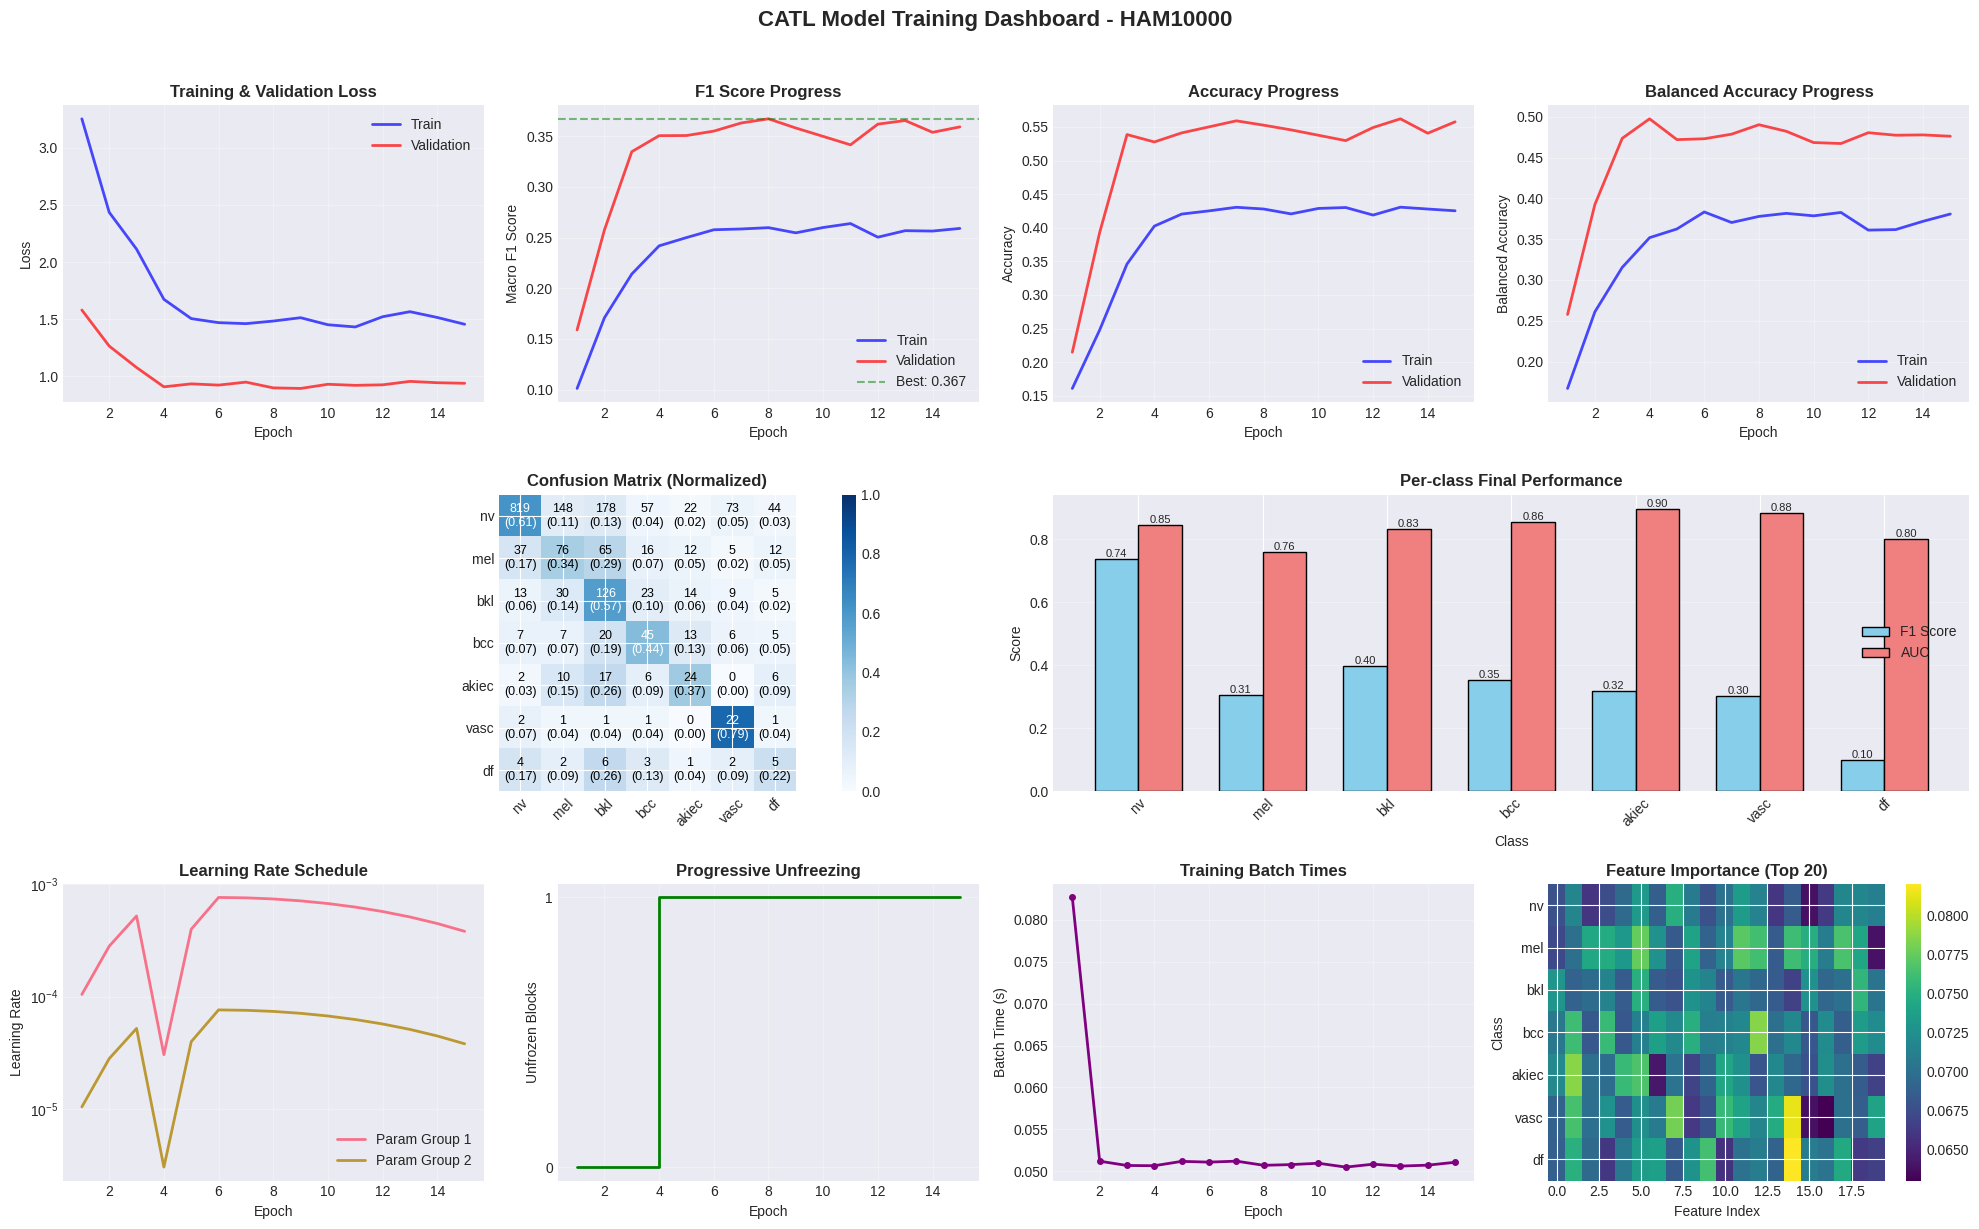

   📊 Interactive plots saved as HTML files
   📋 Performance summary saved as CSV and HTML
✅ Visualizations saved to: /kaggle/working/catl_results/visualizations

📄 Generating detailed report...
   📄 Report saved to: /kaggle/working/catl_results/kaggle_report.txt

📋 TRAINING SUMMARY:
   Best Validation F1: 0.3672
   Best Balanced Accuracy: 0.4976
   Training completed in 15 epochs
   All results saved to: /kaggle/working/catl_results

✅ Kaggle Pipeline Complete!

✅ All done! Check the output files in /kaggle/working/


In [5]:
# =========== CELL 9: TRAINING PIPELINE ===========
"""
Main Training Pipeline for Kaggle
"""

def kaggle_training_pipeline():
    """Complete training pipeline for Kaggle"""
    
    print("🚀 Starting Kaggle CATL Training Pipeline")
    print("="*60)
    
    # Create save directory
    save_dir = '/kaggle/working/catl_results'
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Create trainer
    print("\n⚙️  Initializing Kaggle Trainer...")
    trainer = KaggleCATLTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        class_weights=class_weights,
        lr=1e-3,
        backbone_lr_ratio=0.1,
        gamma=2.0,
        num_epochs=20,  # 20 epochs as requested
        device=device,
        save_dir=save_dir
    )
    
    # 2. Train the model
    print("\n🔥 Starting Training...")
    history = trainer.train()
    
    # 3. Get final validation results
    print("\n📊 Getting final validation results...")
    trainer.model.eval()
    val_results = trainer.val_metrics.compute()
    
    # 4. Create visualizations
    print("\n🎨 Creating visualizations...")
    viz_fig = create_kaggle_visualizations(
        model=trainer.model,
        history=history,
        val_results=val_results,
        class_names=CLASS_NAMES,
        save_dir=save_dir
    )
    
    # 5. Generate detailed report
    print("\n📄 Generating detailed report...")
    generate_kaggle_report(trainer, history, val_results, save_dir)
    
    print("\n" + "="*60)
    print("✅ Kaggle Pipeline Complete!")
    print("="*60)
    
    return trainer, history, val_results

def generate_kaggle_report(trainer, history, val_results, save_dir):
    """Generate comprehensive Kaggle report"""
    
    report_path = os.path.join(save_dir, 'kaggle_report.txt')
    
    with open(report_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("CATL MODEL - KAGGLE TRAINING REPORT\n")
        f.write("="*70 + "\n\n")
        
        f.write("1. MODEL CONFIGURATION\n")
        f.write("-"*40 + "\n")
        f.write(f"Backbone: {trainer.model.backbone_name}\n")
        f.write(f"Feature dimension: {trainer.model.in_features}\n")
        f.write(f"Final unfrozen blocks: {trainer.model.unfrozen_blocks}\n")
        f.write(f"Number of classes: {len(CLASS_NAMES)}\n")
        f.write(f"Training epochs: {len(history['epoch'])}\n\n")
        
        f.write("2. TRAINING PERFORMANCE\n")
        f.write("-"*40 + "\n")
        f.write(f"Best Validation F1: {max(history['val_f1']):.4f}\n")
        f.write(f"Best Validation Accuracy: {max(history['val_acc']):.4f}\n")
        f.write(f"Best Balanced Accuracy: {max(history['val_balanced_acc']):.4f}\n")
        f.write(f"Best Epoch: {np.argmax(history['val_f1']) + 1}\n")
        f.write(f"Final Training Loss: {history['train_loss'][-1]:.4f}\n")
        f.write(f"Final Validation Loss: {history['val_loss'][-1]:.4f}\n\n")
        
        f.write("3. PER-CLASS PERFORMANCE (Final Epoch)\n")
        f.write("-"*40 + "\n")
        f.write(f"{'Class':<10} {'F1':<8} {'AUC':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<10}\n")
        f.write("-"*70 + "\n")
        
        for i, class_name in enumerate(CLASS_NAMES):
            f1 = history['per_class_f1'][-1][i]
            auc = history['per_class_auc'][-1][i]
            acc = history['per_class_acc'][-1][i]
            prec = val_results['per_class_precision'][i]
            rec = val_results['per_class_recall'][i]
            
            f.write(f"{class_name:<10} {f1:<8.3f} {auc:<8.3f} {acc:<10.3f} {prec:<10.3f} {rec:<10.3f}\n")
        
        f.write("\n")
        
        f.write("4. CONFUSION MATRIX SUMMARY\n")
        f.write("-"*40 + "\n")
        cm = val_results['confusion_matrix']
        for i, class_name in enumerate(CLASS_NAMES):
            correct = cm[i, i]
            total = cm[i].sum()
            accuracy = correct / total if total > 0 else 0
            f.write(f"{class_name:<6}: {correct}/{total} correct ({accuracy:.1%})\n")
        
        f.write("\n")
        
        f.write("5. TRAINING INSIGHTS\n")
        f.write("-"*40 + "\n")
        
        # Check for overfitting
        train_f1_final = history['train_f1'][-1]
        val_f1_final = history['val_f1'][-1]
        gap = train_f1_final - val_f1_final
        
        if gap > 0.15:
            f.write("⚠️  STRONG OVERFITTING DETECTED\n")
            f.write(f"   Train-Val F1 gap: {gap:.3f}\n")
            f.write("   Recommendation: Increase regularization, add more augmentation\n")
        elif gap > 0.08:
            f.write("⚠️  MODERATE OVERFITTING DETECTED\n")
            f.write(f"   Train-Val F1 gap: {gap:.3f}\n")
            f.write("   Recommendation: Consider early stopping or weight decay\n")
        else:
            f.write("✅ GOOD GENERALIZATION\n")
            f.write(f"   Train-Val F1 gap: {gap:.3f}\n")
        
        f.write("\n")
        
        f.write("6. RARE CLASS PERFORMANCE\n")
        f.write("-"*40 + "\n")
        rare_classes = ['akiec', 'vasc', 'df']
        for rare in rare_classes:
            if rare in CLASS_NAMES:
                idx = CLASS_NAMES.index(rare)
                f1 = history['per_class_f1'][-1][idx]
                f.write(f"{rare:<6}: F1 = {f1:.3f}")
                if f1 < 0.5:
                    f.write(" ⚠️ Needs improvement")
                f.write("\n")
        
        f.write("\n")
        
        f.write("7. FILES SAVED\n")
        f.write("-"*40 + "\n")
        for root, dirs, files in os.walk(save_dir):
            for file in files:
                rel_path = os.path.relpath(os.path.join(root, file), save_dir)
                size = os.path.getsize(os.path.join(root, file))
                f.write(f"{rel_path:<40} {size/1024:.1f} KB\n")
    
    print(f"   📄 Report saved to: {report_path}")
    
    # Also print a summary to console
    print("\n📋 TRAINING SUMMARY:")
    print(f"   Best Validation F1: {max(history['val_f1']):.4f}")
    print(f"   Best Balanced Accuracy: {max(history['val_balanced_acc']):.4f}")
    print(f"   Training completed in {len(history['epoch'])} epochs")
    print(f"   All results saved to: {save_dir}")

# =========== CELL 10: RUN TRAINING ===========
print("🎬 Starting Kaggle CATL Training Pipeline")
print("="*60)

# Run the training pipeline
trainer, history, val_results = kaggle_training_pipeline()

print("\n✅ All done! Check the output files in /kaggle/working/")

In [6]:
# =========== CELL 11: ADDITIONAL ANALYSIS (OPTIONAL) ===========
"""
Optional: Additional Analysis and Inference
"""

def analyze_predictions(trainer, val_loader, save_dir='/kaggle/working'):
    """Analyze predictions in detail"""
    
    print("\n🔍 Analyzing predictions in detail...")
    
    trainer.model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    all_images = []
    all_indices = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc="Processing validation set")):
            images = images.to(device)
            logits = trainer.model(images)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            all_images.extend(images.cpu().numpy())
            all_indices.extend(range(batch_idx * len(images), (batch_idx + 1) * len(images)))
    
    # Convert to numpy
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Create detailed analysis DataFrame
    analysis_data = []
    
    for i in range(len(all_targets)):
        true_class = CLASS_NAMES[all_targets[i]]
        pred_class = CLASS_NAMES[all_preds[i]]
        confidence = all_probs[i, all_preds[i]]
        
        analysis_data.append({
            'index': all_indices[i],
            'true_class': true_class,
            'pred_class': pred_class,
            'confidence': confidence,
            'correct': true_class == pred_class,
            'true_idx': all_targets[i],
            'pred_idx': all_preds[i]
        })
    
    df_analysis = pd.DataFrame(analysis_data)
    
    # Save analysis
    analysis_path = os.path.join(save_dir, 'prediction_analysis.csv')
    df_analysis.to_csv(analysis_path, index=False)
    
    print(f"✅ Prediction analysis saved to: {analysis_path}")
    
    # Analyze misclassifications
    misclassified = df_analysis[~df_analysis['correct']]
    
    if len(misclassified) > 0:
        print(f"\n⚠️  Misclassification Analysis:")
        print(f"   Total misclassifications: {len(misclassified)}/{len(df_analysis)} ({len(misclassified)/len(df_analysis):.1%})")
        
        # Most common misclassifications
        confusion_pairs = misclassified.groupby(['true_class', 'pred_class']).size().reset_index(name='count')
        confusion_pairs = confusion_pairs.sort_values('count', ascending=False)
        
        print(f"\n   Most common misclassifications:")
        for _, row in confusion_pairs.head(5).iterrows():
            print(f"     {row['true_class']} → {row['pred_class']}: {row['count']} samples")
    
    return df_analysis

# Run optional analysis
print("\n📊 Running optional detailed analysis...")
df_analysis = analyze_predictions(trainer, val_loader)

# Show sample of analysis
print("\n📋 Sample of prediction analysis:")
print(df_analysis.head(10))


📊 Running optional detailed analysis...

🔍 Analyzing predictions in detail...


Processing validation set: 100%|██████████| 63/63 [00:04<00:00, 14.97it/s]

✅ Prediction analysis saved to: /kaggle/working/prediction_analysis.csv

⚠️  Misclassification Analysis:
   Total misclassifications: 887/2003 (44.3%)

   Most common misclassifications:
     nv → bkl: 177 samples
     nv → mel: 147 samples
     nv → vasc: 74 samples
     mel → bkl: 65 samples
     nv → bcc: 58 samples

📋 Sample of prediction analysis:
   index true_class pred_class  confidence  correct  true_idx  pred_idx
0      0         nv         nv    0.999883     True         0         0
1      1         nv         nv    0.999622     True         0         0
2      2         nv        mel    0.867622    False         0         1
3      3        mel         nv    0.999537    False         1         0
4      4         nv         nv    0.779686     True         0         0
5      5        mel        bkl    0.998884    False         1         2
6      6        bkl        bkl    0.591394     True         2         2
7      7         nv        bkl    0.978568    False         0        